In [53]:
import sys
from pathlib import Path
from mllm.markov_games.rollout_tree import *
from mllm.markov_games.gather_and_export_utils import *
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [54]:
rollout_trees = get_rollout_trees("/home/mila/d/dereck.piche/scratch/llm_negotiation/2025_08/debug_2025-08-07___15-43-43/seed_1000")
print(f"Rollout trees from {len(rollout_trees)} iterations loaded.")

Rollout trees from 78 iterations loaded.


In [55]:
def analyze_agent_rewards(rollout_trees_by_iteration):
    """
    Analyze agent rewards across iterations, calculating mean rewards per time step.
    
    Args:
        rollout_trees_by_iteration: List of lists, where each inner list contains 
                                  RolloutTreeRootNode objects for one iteration
    """
    iteration_numbers = []
    agent_rewards_by_iteration = defaultdict(list)
    
    for iteration_idx, rollout_trees in enumerate(rollout_trees_by_iteration):
        if not rollout_trees:
            continue
            
        # Collect rewards from all rollout trees in this iteration
        iteration_agent_rewards = defaultdict(list)
        
        for tree in rollout_trees:
            # Get main path for this tree
            main_path, _ = get_rollout_tree_paths(tree)
            
            # Get all agents
            agents = get_all_agents(tree)
            
            # Gather rewards for each agent in the main path
            all_rewards = gather_all_rewards(main_path)
            
            if all_rewards:
                # Calculate mean reward per time step for each agent
                for agent in agents:
                    agent_step_rewards = [step_rewards.get(agent, 0) for step_rewards in all_rewards]
                    # Mean across time steps for this agent in this tree
                    agent_mean_per_step = np.mean(agent_step_rewards)
                    iteration_agent_rewards[agent].append(agent_mean_per_step)
        
        # Calculate mean across all trees for this iteration
        if iteration_agent_rewards:
            iteration_numbers.append(iteration_idx)
            
            for agent, rewards in iteration_agent_rewards.items():
                # Mean across all trees for this agent in this iteration
                agent_iteration_mean = np.mean(rewards)
                agent_rewards_by_iteration[agent].append(agent_iteration_mean)
    
    return iteration_numbers, agent_rewards_by_iteration


In [56]:
def plot_agent_reward_evolution(iteration_numbers, agent_rewards_by_iteration, output_path=None):
    """
    Create a single plot showing individual agent reward evolution.
    """
    # Create a smaller, focused plot
    plt.figure(figsize=(8, 5))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(agent_rewards_by_iteration)))
    
    for i, (agent, rewards) in enumerate(agent_rewards_by_iteration.items()):
        plt.plot(iteration_numbers[:len(rewards)], rewards, 
                marker='o', linewidth=2, markersize=5, 
                color=colors[i], label=f'Agent {agent}')
    
    plt.title('Individual Agent Reward Evolution\n(Mean per Time Step)', fontsize=12, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Reward per Time Step')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    
    plt.show()
    
    # Print summary statistics
    if agent_rewards_by_iteration:
        print(f"\nSummary:")
        print(f"Number of iterations: {len(iteration_numbers)}")
        for agent, rewards in agent_rewards_by_iteration.items():
            if rewards:
                print(f"Agent {agent}: {rewards[0]:.3f} → {rewards[-1]:.3f} (change: {rewards[-1] - rewards[0]:.3f})")
    else:
        print("No reward data found!")


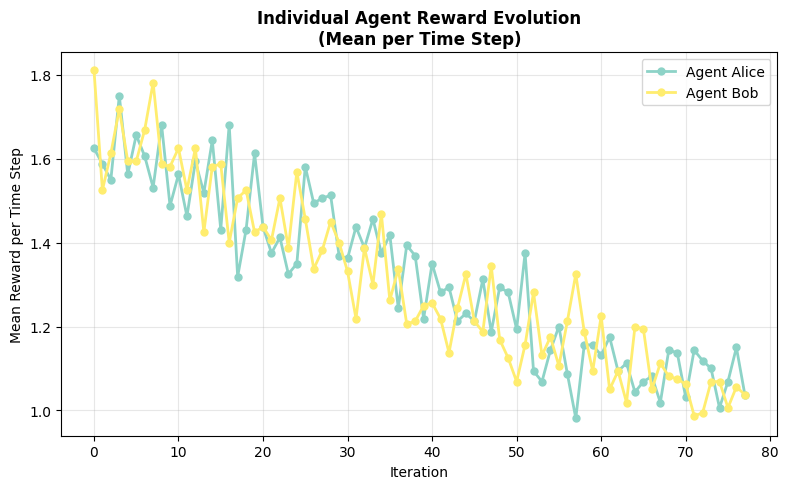


Summary:
Number of iterations: 78
Agent Alice: 1.625 → 1.038 (change: -0.587)
Agent Bob: 1.812 → 1.038 (change: -0.775)


In [57]:
# Analyze agent reward evolution (mean across time steps and iterations)
iteration_numbers, agent_rewards_by_iteration = analyze_agent_rewards(rollout_trees)

# Create the plot
plot_agent_reward_evolution(iteration_numbers, agent_rewards_by_iteration)
